# Logistic Regression - NumPy

El objetivo de éste ejercicio es que implementen paso a paso los building blocks del modelo de regresión logística, para finalmente crear una clase del modelo.

## Cargamos las Librerías

In [1]:
import numpy as np
import time
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (20, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 20

import pickle as pkl 

## Implementación de Building Blocks del Modelo

A continuación, se deberán implementar paso a paso los distintos bloques de código que conforman el modelo, junto con algunas funciones auxiliares.

### Función Sigmoid

Implementar la función: $g(z) = \frac{1}{1 + e^{-z}}$ en NumPy

In [2]:
def sigmoid(z):
    """
    Sigmoid function implmementation with numpy
    
    Args:
        z (numpy array): input data
        
    Returns:
        numpy array: sigmoid function output
    """
    g_z = 1 / (1 + np.exp(-z))
    return g_z

### Binary Cross Entropy

Implementar la función de costo: $J(w) = \frac{1}{n}\sum_{i=1}^{n}L\left ( \hat{y},y \right )= \frac{1}{n}\sum_{i=1}^{n}\left [y^{(i)}log(\hat{y}^{(i)})+ (1-y^{(i)})log(1-\hat{y}^{(i)}) \right ]$

In [3]:
def cost_function (y_real, y_predicted):
    """
    Cost function implmementation with numpy
    
    Args:
        y_real (numpy array): array of real outputs
        y_predicted (numpy array): array of predicted outputs
        
    Returns:
        float: cost function value
    """
    j_w=-np.sum(np.multiply(y_real,np.log(y_predicted)) + np.multiply(1-y_real,np.log(1-y_predicted))) / \
        y_real.shape[0]
    
    return j_w

### Gradiente

Implementar el gradiente de la función costo respecto de los parámetros: $\frac{\partial J(w)}{\partial w} = \frac{1}{n}\sum_{i=1}^{n}\left ( \hat{y}^{i}-y^{i}\right )\bar{x}^i$

In [4]:
def gradient(x,y_real,y_predicted):
    """
    Gradient of cost function implementation in numpy
    
    Args:
        x (numpy array): array of input values
        y_real (numpy array): array of real outputs
        y_predicted (numpy array): array of predicted outputs
        
    Returns:
        numpy array: gradient for each feature
    """
    error = (y_predicted-y_real)
    dj_w = np.sum(error[:,np.newaxis]*x,axis=0) / y_real.shape[0]
    return dj_w

### Normalización

Implementar normalización Z-score de las features de entrada

In [5]:
class ZScore:
    """
    Z-score normalization class implementation with numpy
    """
    features_mean = None
    features_std = None
    
    def __init__(self):
        pass
    
    def fit(self, x):
        self.features_mean = np.mean(x,axis=0)
        self.features_std = np.std(x,axis=0)
    
    def transform(self, x):
        x_norm = (x - self.features_mean)/self.features_std
        return x_norm

### Métricas (Precision, Recall y Accuracy)

Implementar las métricas en NumPy

In [6]:
class BaseMetric:
    """
    Metric base class
    """
    def __init__(self):
        pass

    def __call__(self, truth, prediction):
        pass
    
    
class Precision(BaseMetric):
    """
    Precision metric
    """
    def __init__(self):
        pass

    def __call__(self, truth, prediction):
        TP = np.sum(truth & prediction)
        FP = np.sum((1-truth) & (prediction))
        precision= TP / (TP+FP)
        return precision

    
class Recall(BaseMetric):
    """
    Precision metric
    """
    def __init__(self):
        pass

    def __call__(self, truth, prediction):
        TP = np.sum(truth & prediction)
        FN = np.sum((truth) & (1-prediction))
        recall= TP / (TP+FN)
        return recall

    
class Accuracy(BaseMetric):
    """
    Precision metric
    """
    def __init__(self):
        pass

    def __call__(self, truth, prediction):
        TP = np.sum(truth & prediction)
        TN = np.sum((1-truth) & (1-prediction))
        FP = np.sum((1-truth) & (prediction))
        FN = np.sum((truth) & (1-prediction))
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        return accuracy

### Implementar función fit

Utilizas los bloques anteriores, junto con la implementación en NumPy del algoritmo Mini-Batch gradient descent, para crear la función fit de nuestro modelo de regresión logística. Cada un determinado número de epochs calculen el loss, almacénenlo en una lista y hagan un log de los valores. La función debe devolver los parámetros ajustados.

In [7]:
def fit(X, y, lr, b, epochs, bias=True):
    
    if len(X.shape)<2:
        X=X[:,np.newaxis]
    if bias:
        X=np.append(X, np.ones(shape=(X.shape[0],1)), axis = 1)
        
    n = X.shape[0]
    m = X.shape[1]

    # initialize random weights
    W = np.zeros(shape=(m, 1),dtype='float64')
        
    loss_list = []
    # iterate over the n_epochs
    for j in range(epochs):
        
        # Shuffle all the samples 
        idx = np.random.permutation(X.shape[0])
        X = X[idx]
        y = y[idx]

        # Calculate the batch size in samples as a function of the number of batches
        batch_size = int(len(X) / b)

        # Iterate over the batches
        for i in range(0, len(X), batch_size):

            end = i + batch_size if i + batch_size <= len(X) else len(X)
            batch_x = X[i: end] # batch_size*m
            batch_y = y[i: end] # batch_size*1

            # Calculate the prediction for the whole batch
            prediction = sigmoid(batch_x@W)  # batch_sizex1
            prediction=prediction[:,0]

            # Calculate the gradient for the batch
            grad = gradient(batch_x, batch_y, prediction)

            # Update the weights
            W = W - (lr * grad[:,np.newaxis])
            
            # Calculate new loss
            loss= cost_function(y, sigmoid(X@W)[:,0])
            loss_list.append(loss)
        if j>0 and j//10==0:
            print ('Loss epoch {}'.format(j) + ': {}'.format(loss))

    return W
    

### Implementar función predict

Implementar la función predict usando los parámetros calculados y la función sigmoid. Prestar atención a las transformaciones de los datos de entrada. Asimismo, se debe tomar una decisión respecto de los valores de salida como: $p\geq 0.5 \to 1, p<0.5 \to 0$

In [8]:
def predict (X, W):
    if len(X.shape)<2:
        X=X[:,np.newaxis]
        
    if W.shape[0]>X.shape[1]:
        X=np.append(X, np.ones(shape=(X.shape[0],1)), axis = 1)
    
    prediction = sigmoid(X@W)  # batch_sizex1
    prediction = prediction[:,0]
    prediction = (prediction>=0.5) * 1
    
    return prediction
    

## Armar una clase LogisticRegression

Armar una clase LogisticRegression que herede de BaseModel y tenga la siguiente estructura:

In [9]:
class BaseModel():
    """
    Base class for models
    """
    def __init__(self):
        pass
    
    def fit(self, X, y, lr, b, epochs, bias=True):
        return NotImplemented
    
    def predict(self, X):
        return NotImplemented

In [10]:
class myLogisticRegression(BaseModel):
    
    W = None
    bias = True
    loss_list = []
    
    def sigmoid(self, x):
        g_x = 1 / (1 + np.exp(-x))
        return g_x
    
    def cost_function (y_real, y_predicted):
        j_w=np.mean( y_real * np.log(y_predicted) + (1.0-y_real) * np.log((1.0-y_predicted)))
        return j_w
    
    def gradient(x,y_real,y_predicted):
        error = (y_predicted-y_real)
        dj_w = np.sum(error[:,np.newaxis]*x,axis=0) / y_real.shape[0]
        return dj_w

    def fit(self, X, y, lr, b, epochs, bias=True, verbose=False):
        if len(X.shape)<2:
            X=X[:,np.newaxis]
        if bias:
            X=np.append(X, np.ones(shape=(X.shape[0],1)), axis = 1)

        n = X.shape[0]
        m = X.shape[1]

        # initialize random weights
        W = np.zeros(shape=(m, 1),dtype='float64')

        # iterate over the n_epochs
        for j in range(1,epochs+1):
            # Shuffle all the samples 
            idx = np.random.permutation(X.shape[0])
            X = X[idx]
            y = y[idx]

            # Calculate the batch size in samples as a function of the number of batches
            batch_size = int(len(X) / b)

            # Iterate over the batches
            for i in range(0, len(X), batch_size):

                end = i + batch_size if i + batch_size <= len(X) else len(X)
                batch_x = X[i: end] # batch_size*m
                batch_y = y[i: end] # batch_size*1

                # Calculate the prediction for the whole batch
                prediction = sigmoid(batch_x@W)  # batch_sizex1
                prediction=prediction[:,0]

                # Calculate the gradient for the batch
                grad = gradient(batch_x, batch_y, prediction)

                # Update the weights
                W = W - (lr * grad[:,np.newaxis])

                # Calculate new loss
                loss= cost_function(y, sigmoid(X@W)[:,0])
                self.loss_list.append(loss)
                
            if j>0 and j % 10==0 and verbose:
                print ('Loss epoch {}'.format(j) + ': {}'.format(loss))

        self.W = W
        self.bias = bias
        
    def predict(self, X):
        if len(X.shape)<2:
            X=X[:,np.newaxis]

        if self.bias:
            X=np.append(X, np.ones(shape=(X.shape[0],1)), axis = 1)

        prediction = sigmoid(X@self.W)  # batch_sizex1
        prediction = prediction[:,0]
        prediction = (prediction>=0.5) * 1

        return prediction

## Testear con Datasets sintéticos

La librería Scikit-Learn tiene una función make_classification que nos permite armar datasets de prueba para problemas de clasificación. Prueben con datasets que tengan varios clusters por clase, que tengan menor o mayor separación y calculen las métricas en cada caso.

In [11]:
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1)
x_train, x_test, y_train, y_test= model_selection.train_test_split(X, \
                                                                   y, \
                                                                   test_size=0.2, \
                                                                   shuffle=True)

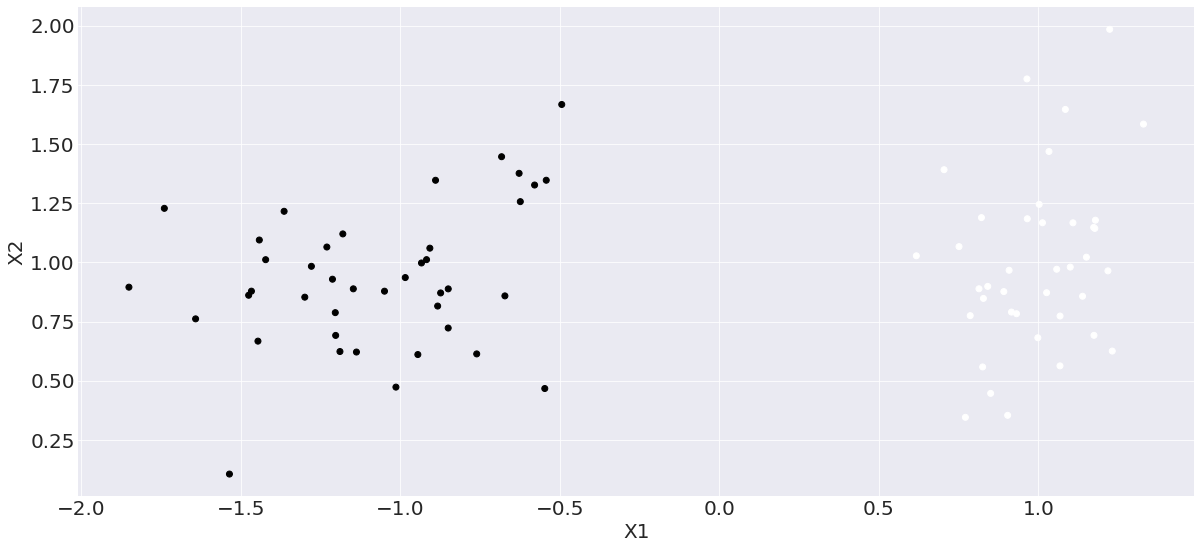

In [12]:
plt.figure()
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [13]:
scaler = ZScore()
scaler.fit(x_train)
x_train_transformed = scaler.transform(x_train)
model = myLogisticRegression()
model.fit(x_train_transformed,y_train,0.5,10,1000,True,True)

Loss epoch 10: 0.03144043279549984
Loss epoch 20: 0.016831058732306337
Loss epoch 30: 0.011659604688809819
Loss epoch 40: 0.008980541078515921
Loss epoch 50: 0.007331777636379461
Loss epoch 60: 0.006210554244017887
Loss epoch 70: 0.00539679452723945
Loss epoch 80: 0.0047781176679293404
Loss epoch 90: 0.00429115662465302
Loss epoch 100: 0.003897530299265036
Loss epoch 110: 0.003572425998558694
Loss epoch 120: 0.003299157600006295
Loss epoch 130: 0.003066186793775536
Loss epoch 140: 0.0028650848812401346
Loss epoch 150: 0.0026896308602970833
Loss epoch 160: 0.0025351704262568703
Loss epoch 170: 0.0023981065496533026
Loss epoch 180: 0.0022756075372712776
Loss epoch 190: 0.002165472268503689
Loss epoch 200: 0.0020658689579420427
Loss epoch 210: 0.001975348012553075
Loss epoch 220: 0.0018927092835109127
Loss epoch 230: 0.001816950339396655
Loss epoch 240: 0.0017472343696085988
Loss epoch 250: 0.0016828584527951579
Loss epoch 260: 0.0016232183204025748
Loss epoch 270: 0.0015678092349334996
L

In [14]:
x_test_transformed=scaler.transform(x_test)
y_predicted = model.predict(x_test_transformed)

metrics = [ ('Precision', Precision()) , \
            ('Accuracy', Accuracy()) , \
            ('Recall', Recall())
          ]

for metric in metrics:
    print(metric[0] + ": {}".format(metric[1](y_test,y_predicted)))

Precision: 1.0
Accuracy: 1.0
Recall: 1.0


In [15]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color= "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.grid(False)
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    

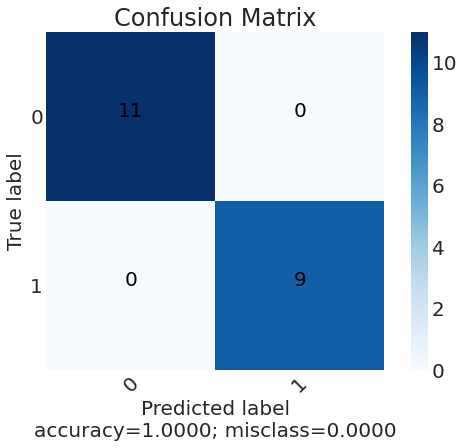

In [16]:
cm =confusion_matrix(y_test, np.array(y_predicted))
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = ['0', '1'],
                      title        = "Confusion Matrix")

In [17]:
# Probamos con distintos modelos
def model1_test(n_samples, n_features, n_redundant, n_informative, n_clusters_per_class):
    X, y = make_classification(n_samples=n_samples,\
                               n_features=n_features, \
                               n_redundant=n_redundant, \
                               n_informative=n_informative, \
                               random_state=1, \
                               n_clusters_per_class=n_clusters_per_class)
    x_train, x_test, y_train, y_test= model_selection.train_test_split(X, \
                                                                   y, \
                                                                   test_size=0.2, \
                                                                   shuffle=True)
    
    scaler = ZScore()
    scaler.fit(x_train)
    x_train_transformed = scaler.transform(x_train)
    model = myLogisticRegression()
    model.fit(x_train_transformed,y_train,0.5,10,1000,True)
    x_test_transformed=scaler.transform(x_test)
    y_predicted = model.predict(x_test_transformed)

    metrics = [ ('Precision', Precision()) , \
                ('Accuracy', Accuracy()) , \
                ('Recall', Recall())
              ]

    for metric in metrics:
        print(metric[0] + ": {}".format(metric[1](y_test,y_predicted)))
        
    cm =confusion_matrix(y_test, np.array(y_predicted))
    plot_confusion_matrix(cm, 
                          normalize    = False,
                          target_names = ['0', '1'],
                          title        = "Confusion Matrix")

Precision: 0.9574468085106383
Accuracy: 0.96
Recall: 0.9574468085106383


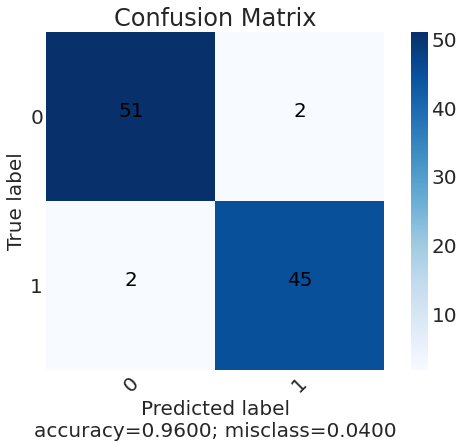

In [18]:
model1_test(n_samples= 500,n_features=10, n_redundant=0, n_informative=7,n_clusters_per_class=1)


Precision: 0.5714285714285714
Accuracy: 0.56
Recall: 0.6153846153846154


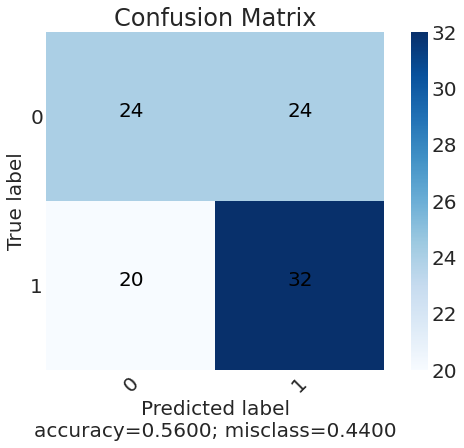

In [19]:
model1_test(n_samples= 500,n_features=10, n_redundant=3, n_informative=7,n_clusters_per_class=5)

Notamos que a mayor cantidad de features y muestras, necesita mayor cantidad de epochs para llegar a a una buena solución.

También al incrementar la cantidad de clusters, la separación se vuelve mas compleja

### Comparamos contra scikit-learn

In [20]:
X, y = make_classification(n_samples=1000,\
                           n_features=10, \
                           n_redundant=3, \
                           n_informative=7, \
                           random_state=1, \
                           n_clusters_per_class=3)
x_train, x_test, y_train, y_test= model_selection.train_test_split(X, \
                                                               y, \
                                                               test_size=0.2, \
                                                               shuffle=True)

scaler = ZScore()
scaler.fit(x_train)
x_train_transformed = scaler.transform(x_train)

model1 = myLogisticRegression()
model.fit(x_train_transformed,y_train,0.5,10,1000,True)
model2 = LogisticRegression(random_state=0).fit(x_train_transformed,y_train)

x_test_transformed=scaler.transform(x_test)
y_predicted = model.predict(x_test_transformed)
y_predicted2 = model2.predict(x_test_transformed)


metrics = [ ('Precision', Precision()) , \
            ('Accuracy', Accuracy()) , \
            ('Recall', Recall())
          ]

print('Metricas mi modelo:')
for metric in metrics:
    print(metric[0] + ": {}".format(metric[1](y_test,y_predicted)))
print('---------------------')
print('Metricas modelo sklearn')
for metric in metrics:
    print(metric[0] + ": {}".format(metric[1](y_test,y_predicted2)))

Metricas mi modelo:
Precision: 0.7058823529411765
Accuracy: 0.735
Recall: 0.8235294117647058
---------------------
Metricas modelo sklearn
Precision: 0.7083333333333334
Accuracy: 0.74
Recall: 0.8333333333333334


Notamos que las métricas son prácticamente iguales en nuestra implementación y la de scikit-learn

### Comparación con regularizacion

In [21]:
class RegularizedLogisticRegression(BaseModel):
    
    W = None
    bias = True
    loss_list = []
    
    def sigmoid(self, x):
        g_x = 1 / (1 + np.exp(-x))
        return g_x
    
    def cost_function (y_real, y_predicted):
        j_w=np.mean( y_real * np.log(y_predicted) + (1.0-y_real) * np.log((1.0-y_predicted)))
        return j_w
    
    def gradient(x,y_real,y_predicted):
        error = (y_predicted-y_real)
        dj_w = np.sum(error[:,np.newaxis]*x,axis=0) / y_real.shape[0]
        return dj_w

    def fit(self, X, y, lr, regularization, b, epochs, bias=True, verbose=False):
        if len(X.shape)<2:
            X=X[:,np.newaxis]
        if bias:
            X=np.append(X, np.ones(shape=(X.shape[0],1)), axis = 1)

        n = X.shape[0]
        m = X.shape[1]

        # initialize random weights
        W = np.zeros(shape=(m, 1),dtype='float64')

        # iterate over the n_epochs
        for j in range(1,epochs+1):
            # Shuffle all the samples 
            idx = np.random.permutation(X.shape[0])
            X = X[idx]
            y = y[idx]

            # Calculate the batch size in samples as a function of the number of batches
            batch_size = int(len(X) / b)

            # Iterate over the batches
            for i in range(0, len(X), batch_size):

                end = i + batch_size if i + batch_size <= len(X) else len(X)
                batch_x = X[i: end] # batch_size*m
                batch_y = y[i: end] # batch_size*1

                # Calculate the prediction for the whole batch
                prediction = sigmoid(batch_x@W)  # batch_sizex1
                prediction=prediction[:,0]

                # Calculate the gradient for the batch
                grad = gradient(batch_x, batch_y, prediction)

                # Update the weights
                W = (1-2*regularization*lr)* W - (2*lr * grad[:,np.newaxis])

                # Calculate new loss
                loss= cost_function(y, sigmoid(X@W)[:,0])
                self.loss_list.append(loss)
                
            if j>0 and j % 10==0 and verbose:
                print ('Loss epoch {}'.format(j) + ': {}'.format(loss))

        self.W = W
        self.bias = bias
        
    def predict(self, X):
        if len(X.shape)<2:
            X=X[:,np.newaxis]

        if self.bias:
            X=np.append(X, np.ones(shape=(X.shape[0],1)), axis = 1)

        prediction = sigmoid(X@self.W)  # batch_sizex1
        prediction = prediction[:,0]
        prediction = (prediction>=0.5) * 1

        return prediction

In [22]:
X, y = make_classification(n_samples=1000,\
                           n_features=10, \
                           n_redundant=3, \
                           n_informative=7, \
                           random_state=1, \
                           n_clusters_per_class=3)
x_train, x_test, y_train, y_test= model_selection.train_test_split(X, \
                                                               y, \
                                                               test_size=0.2, \
                                                               shuffle=True)

scaler = ZScore()
scaler.fit(x_train)
x_train_transformed = scaler.transform(x_train)

model1 = myLogisticRegression()
model.fit(x_train_transformed,y_train,0.5,10,1000,True)
model2 = RegularizedLogisticRegression()
model2.fit(x_train_transformed,y_train,0.5,0.1,10,1000,True)

x_test_transformed=scaler.transform(x_test)
y_predicted = model.predict(x_test_transformed)
y_predicted2 = model2.predict(x_test_transformed)


metrics = [ ('Precision', Precision()) , \
            ('Accuracy', Accuracy()) , \
            ('Recall', Recall())
          ]

print('Metricas mi modelo:')
for metric in metrics:
    print(metric[0] + ": {}".format(metric[1](y_test,y_predicted)))
print('---------------------')
print('Metricas modelo regularizado')
for metric in metrics:
    print(metric[0] + ": {}".format(metric[1](y_test,y_predicted2)))

Metricas mi modelo:
Precision: 0.7757009345794392
Accuracy: 0.815
Recall: 0.8645833333333334
---------------------
Metricas modelo regularizado
Precision: 0.7745098039215687
Accuracy: 0.8
Recall: 0.8229166666666666


Observamos que con la regularización hay poca diferencia

### Chequeo de performance en dataset propio

Utilizaremos como dataset, un dataset privado.
Del mismo extraemos una señal que indica la fuerza aplicada para crear un sello en materiales con cavidades que se someten a alta presión interna como parte de su testeo de calidad.

La señal comienza en cero por unos segundos hasta que se forma el sello, y luego se aplica fuerza para mantener el sello con alta presión interna.

Una anomalía común es que el sello pierda fuerza por fugas o fisuras. El dataset utilizado contiene 200 ciclos de testeo correctos y 200 ciclos con anomalía.

In [23]:
#Cargamos el dataset con pickle
with open('./dataset/dataset.pkl','rb') as file:
    data=pkl.load(file)
    
with open('./dataset/dataset_classes.pkl','rb') as file:
    data_classes=pkl.load(file)

#Classes normalization
data_classes=data_classes-1
data_classes=np.array(data_classes,dtype='int32')

In [24]:
data.shape

(400, 800)

Text(0.5, 1.0, 'Funcionamiento con perdida')

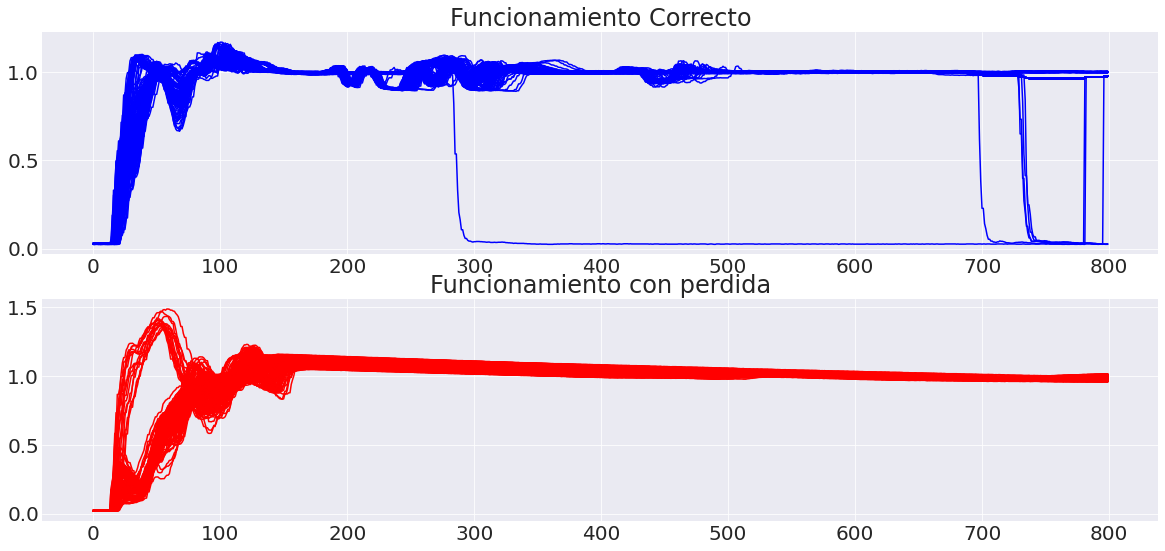

In [25]:
fig, axs = plt.subplots(2)
for i in range(0,200):
    axs[0].plot(data[i,:],color='blue',label=None)
axs[0].set_title("Funcionamiento Correcto")

for i in range(200,400):
    axs[1].plot(data[i,:],color='red',label=None)
axs[1].set_title("Funcionamiento con perdida")

In [26]:
x_train, x_test, y_train, y_test= model_selection.train_test_split(data, \
                                                                    data_classes, \
                                                                    test_size=0.4, \
                                                                    shuffle=True)

scaler = ZScore()
scaler.fit(x_train)
x_train_transformed = scaler.transform(x_train)

model = LogisticRegression(random_state=0).fit(x_train_transformed,y_train)

x_test_transformed=scaler.transform(x_test)
y_predicted = model.predict(x_test_transformed)

metrics = [ ('Precision', Precision()) , \
            ('Accuracy', Accuracy()) , \
            ('Recall', Recall())
          ]

print('Metricas mi modelo:')
for metric in metrics:
    print(metric[0] + ": {}".format(metric[1](y_test,y_predicted)))

Metricas mi modelo:
Precision: 1.0
Accuracy: 1.0
Recall: 1.0


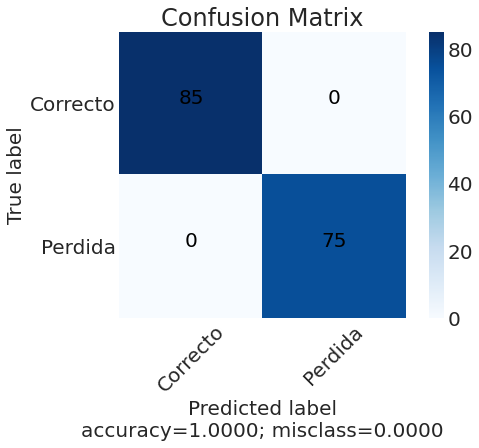

In [27]:
cm =confusion_matrix(y_test, np.array(y_predicted))
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = ['Correcto', 'Perdida'],
                      title        = "Confusion Matrix")

Observamos una performance excelente sobre este dataset